In [2]:
from brian2 import Hz, kHz
from brian2hears import Sound, erbspace, Gammatone, Filterbank
from scipy.signal import butter, filtfilt, sosfiltfilt, lfilter
import librosa as lb
import os, sys
sys.path.append(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [3]:
# ----- Audio data -----

method = "LR"

# Step 1 : Read audio filename.wav to the variable A.
filepath = "../data/stimuli/audiobook_1.wav"
audio_signal, sr = lb.load(filepath, sr=44100)

print(f"Audio signal length: {len(audio_signal)}")
# Cut the signal to a few seconds for now
# plt.plot(audio_signal)
# plt.show()

Audio signal length: 41314177


In [10]:
class EnvelopeFromGammatoneFilterbank(Filterbank):
    """Converts the output of a GammatoneFilterbank to an envelope."""

    def __init__(self, source):
        """Initialize the envelope transformation.

        Parameters
        ----------
        source : Gammatone
            Gammatone filterbank output to convert to envelope
        """
        super().__init__(source)

        self.nchannels = 1

    def buffer_apply(self, input_):
        # 6. take absolute value of the input_
        compressed_subbands = np.abs(input_)**0.6

        combined_envelope = np.sum(compressed_subbands, axis=1)

        return  combined_envelope.reshape(combined_envelope.shape[0], 1)

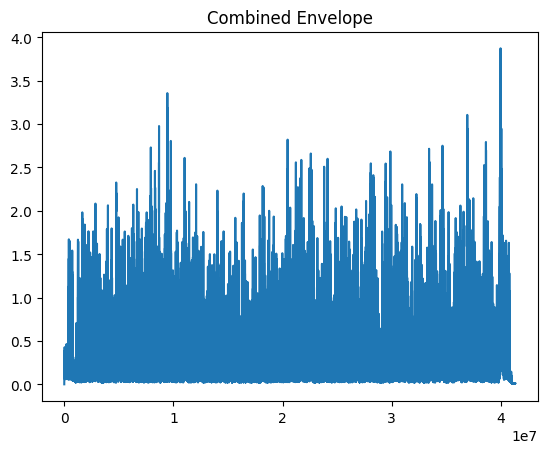

In [11]:
# Convert the numpy array to a Sound object
audio_sound = Sound(audio_signal, samplerate=sr*Hz)

num_filters = 28
center_freqs = np.linspace(50*Hz, 5*kHz, num_filters)
gammatone_filterbank = Gammatone(audio_sound, center_freqs)

envelope_calcuation = EnvelopeFromGammatoneFilterbank(gammatone_filterbank)
combined_envelope = envelope_calcuation.process()

# Plot the combined envelope
plt.plot(combined_envelope)
plt.title("Combined Envelope")

plt.show()

(41314177, 1)
[-9.27184921e-03 -9.27256714e-03 -9.27328506e-03 ...  1.35452312e-11
  1.12130250e-11  9.17463919e-12]
(18737,)


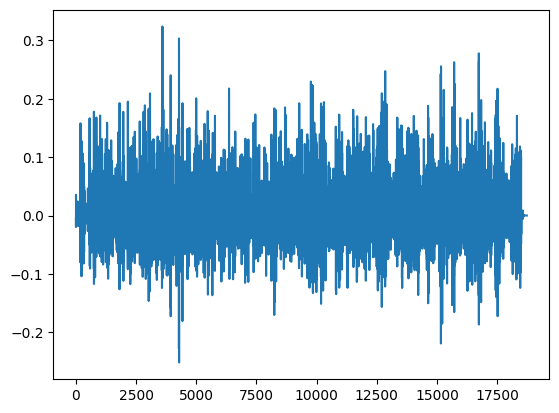

In [36]:
# Choose the frequency range based on the method
low_freq = 1
high_freq = 9  if method == "LR" else 32

# Design a Butterworth bandpass filter
order = 4
nyquist = 0.5 * sr
low = low_freq / nyquist
high = high_freq / nyquist
sos = butter(order, [low, high], btype='band', output='sos')

normalized_envelope = combined_envelope / np.max(combined_envelope)
print(normalized_envelope.shape)
filtered_envelope = sosfiltfilt(sos, normalized_envelope[:, 0])


print(filtered_envelope)

# Choose the downsampling rate based on the method
downsampling_rate = 20  if method == "LR" else 64

resampled_envelope = lb.resample(filtered_envelope, orig_sr=sr, target_sr=downsampling_rate)
print(resampled_envelope.shape)
plt.plot(resampled_envelope)
plt.show()

In [32]:
def load_eeg_data(filename):
    data = np.load(filename)
    return data

def bandpass_filter_eeg(eeg_data, fs, low_freq, high_freq):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_eeg = lfilter(b, a, eeg_data, axis=0)
    return filtered_eeg

def downsample_eeg(filtered_eeg, fs, target_fs):
    downsample_ratio = fs // target_fs
    downsampled_eeg = lb.resample(filtered_eeg.T, orig_sr=fs, target_sr=target_fs).T
    return downsampled_eeg

(116736, 64)
FS: 128
audiobook_1.wav
audiobook_5_2.wav
Downsampled EEG shape: (18240, 64)


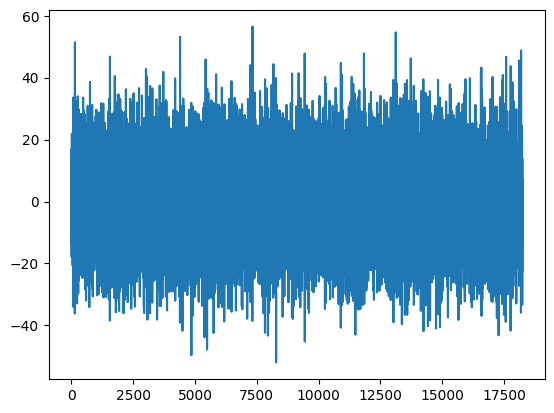

In [33]:
# Load the EEG data
filename = "../data/eeg/sub-001_-_audiobook_1.npz"
eeg_data = load_eeg_data(filename)
eeg = eeg_data['eeg']
print(eeg.shape)
fs = eeg_data['fs']
print(f'FS: {fs}')

print(eeg_data['stimulus_attended'])
print(eeg_data['stimulus_unattended'])

# Filter the EEG signals using a bandpass filter
low_freq, high_freq = 1, 9  # For linear regression
filtered_eeg = bandpass_filter_eeg(eeg, fs, low_freq, high_freq)

# Downsample the EEG signals
target_fs = 20  # For linear regression
downsampled_eeg = downsample_eeg(filtered_eeg, fs, target_fs)
print(f"Downsampled EEG shape: {downsampled_eeg.shape}")
plt.plot(downsampled_eeg[:, 24])
plt.show()

In [38]:
stimuli_train, stimuli_test, eeg_train, eeg_test = train_test_split(resampled_envelope[:18240], downsampled_eeg, test_size=0.2, random_state = 10)

In [40]:
np.save("../data/train_lr/audiobook_1.npy", stimuli_train)
np.save("../data/train_lr/eeg_audiobook_1.npy", eeg_train)
np.save("../data/validate_lr/audiobook_1.npy", stimuli_test)
np.save("../data/validate_lr/eeg_audiobook_1.npy", eeg_test)